In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, RocCurveDisplay, accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from IPython.display import Markdown, display

In [22]:
def apply(
    df,
    model_instance,
    parameter_grid,
    cross_validation=StratifiedKFold(n_splits=5),
    feature_selection=False,
    filter=False,
    oversample=False
):
    parameter_tunning_sample = df.groupby('status', group_keys=False).apply(lambda x: x.sample(frac=0.3))
    training_sample = df.drop(parameter_tunning_sample.index)

    instance_parameter_grid = {}

    for parameter_name, parameter_values in parameter_grid.items():
        instance_parameter_grid[f"model__{parameter_name}"] = parameter_values

    parameter_grid = instance_parameter_grid

    pipeline = []

    if feature_selection:
        rfe = SequentialFeatureSelector(model_instance, n_features_to_select=3)

        if filter:
            rfe = SelectKBest(f_classif, k=10)

        pipeline.append(('feature_selection', rfe))

    if oversample:
        pipeline.append(('sampling', SMOTE(n_jobs=-1)))

    pipeline.append(("model", model_instance))

    pipe = Pipeline(steps=pipeline)

    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(
        accuracy_score), "F1": make_scorer(f1_score)}

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=parameter_grid,
        cv=cross_validation,
        scoring=scoring,
        refit="AUC"
    )
    
    X = parameter_tunning_sample.drop(['status'], axis=1)
    y = parameter_tunning_sample['status']

    scaler = StandardScaler().fit(X)
    X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
    grid_search.fit(X, y)

    # New pipeline
    instance_parameter_grid = {}
    for parameter_name, parameter_values in grid_search.best_params_.items():
        instance_parameter_grid[parameter_name[7:]] = parameter_values
    parameter_grid = instance_parameter_grid

    pipeline = []
    model_instance = RandomForestClassifier(**parameter_grid)
    if feature_selection:
        rfe = SequentialFeatureSelector(model_instance, n_features_to_select=3)

        if filter:
            rfe = SelectKBest(f_classif, k=10)

        pipeline.append(('feature_selection', rfe))

    if oversample:
        pipeline.append(('sampling', SMOTE(n_jobs=-1)))

    pipeline.append(("model", model_instance))

    pipe = Pipeline(steps=pipeline)

    X = training_sample.drop(['status'], axis=1)
    y = training_sample['status']
    scaler = StandardScaler().fit(X)
    X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101) 
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)

    if (feature_selection & oversample):
        display(Markdown("## Feature selection and oversample"))
    elif (feature_selection):
        display(Markdown("## Feature selection"))
    elif (oversample):
        display(Markdown("## Oversample"))
    else:
        display(Markdown("## Neither oversample nor feature selection"))



    display(Markdown(f"### **Classification report:** \n\n {classification_report(y_test, predictions)}"))
    display(Markdown(f"### **Score:** \n\n {pipe.score(X_test, y_test)}"))
    display(Markdown(f"### **Best parameters:** \n\n {grid_search.best_params_}"))
    display(Markdown("### **Confusion matrix:** "))
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
    plt.show()
    display(Markdown("### **ROC curve:** "))

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
                                   
    display_roc.plot()
    plt.show()
    display(Markdown("---"))


    return pipe

In [23]:
def apply_random_forest(df):
    parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
    }
    return (apply(
        df,
        RandomForestClassifier(),
        parameter_grid,
        oversample=oversample,
        feature_selection=feature_selection
    ) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

In [24]:
# Dataframe

df = pd.read_csv('../test_ml/main_df.csv')

## Neither oversample nor feature selection

### **Classification report:** 

               precision    recall  f1-score   support

          -1       0.50      0.12      0.20         8
           1       0.90      0.98      0.94        61

    accuracy                           0.88        69
   macro avg       0.70      0.55      0.57        69
weighted avg       0.85      0.88      0.85        69


### **Score:** 

 0.8840579710144928

### **Best parameters:** 

 {'model__criterion': 'entropy', 'model__max_depth': 15, 'model__n_estimators': 200, 'model__n_jobs': -1}

### **Confusion matrix:** 

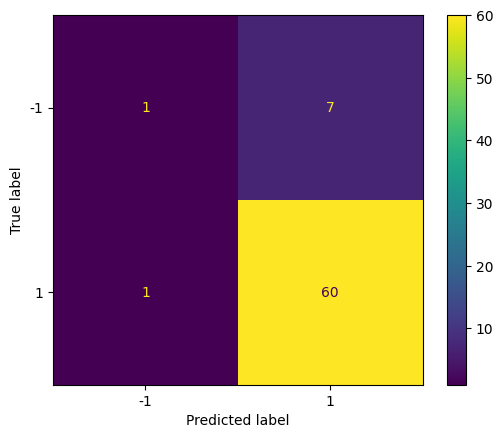

### **ROC curve:** 

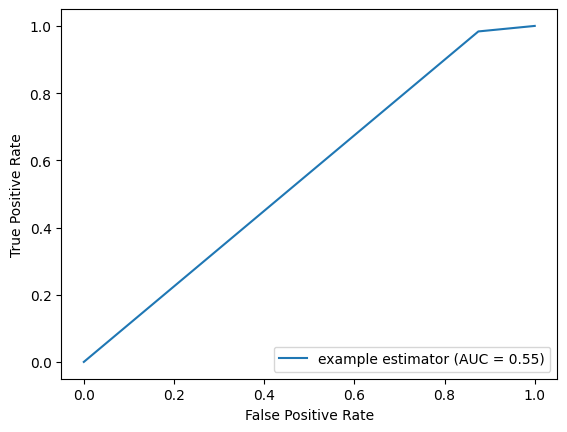

---

KeyboardInterrupt: 

In [25]:
u,p,o,i=apply_random_forest(df)
